In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
with open('/content/gdrive/My Drive/foo.txt', 'w') as f:
  f.write('Hello Google Drive!')
!cat /content/gdrive/My\ Drive/foo.txt

Hello Google Drive!

In [3]:
import os, shutil, copy, ntpath, datetime, zipfile
import keras
from keras import models, layers, callbacks
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img
import tensorflow as tf

import matplotlib.pyplot as plt

import boto3
import glob
import ntpath
import re

import numpy as np
import pandas as pd

Using TensorFlow backend.


In [4]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [0]:
#### Settings
IMAGE_SHAPE=(200, 200, 3)

LIMIT_BATCHES = 30
#LIMIT_BATCHES = None

NUM_EPOCHS = 40
BATCH_SIZE = 25
NUM_CLASSES = 29

# PRETRAIN_MODEL = 'conv_base_local'
# PRETRAIN_MODEL = 'conv_base_vgg16'
PRETRAIN_MODEL = None

In [0]:
import os

#### FilePath Information
DATA_DIR = '/content/gdrive/My Drive/'
#ASL_ALPHABET_DATASET_ZIP = os.path.join(DATA_DIR, 'asl_alphabet_train2.zip')
#LOCAL_DATASET_ZIP = '/tmp/asl_alphabet_train2.zip'
#LOCAL_DATASET = '/tmp/asl_alphabet_train2'


#ASL_ALPHABET_TEST_DATASET_ZIP = os.path.join(DATA_DIR, 'asl_alphabet_test2.zip')
#LOCAL_TEST_DATASET_ZIP = '/tmp/asl_alphabet_test2.zip'
#LOCAL_TEST_DATASET = '/tmp/asl_alphabet_test2'


#SAVED_MODEL_DIR = os.path.join(DATA_DIR, 'models/asl_alphabet')

ASL_ALPHABET_DATASET_ZIP = os.path.join(DATA_DIR, 'asl_alphabet_train1.zip')
LOCAL_DATASET_ZIP = '/tmp/asl_alphabet_train1.zip'
LOCAL_DATASET = '/tmp/asl_alphabet_train1'


ASL_ALPHABET_TEST_DATASET_ZIP = os.path.join(DATA_DIR, 'handsigns.zip')
LOCAL_TEST_DATASET_ZIP = '/tmp/handsigns.zip'
LOCAL_TEST_DATASET = '/tmp/handsigns'


SAVED_MODEL_DIR = os.path.join(DATA_DIR, 'models/asl_handsigns')

In [0]:
if not os.path.isfile(LOCAL_DATASET_ZIP):
  %time shutil.copy(ASL_ALPHABET_DATASET_ZIP, LOCAL_DATASET_ZIP)

In [0]:
if not os.path.isfile(LOCAL_TEST_DATASET_ZIP):
  %time shutil.copy(ASL_ALPHABET_TEST_DATASET_ZIP, LOCAL_TEST_DATASET_ZIP)

In [9]:
if not os.path.isdir(LOCAL_DATASET):
  with zipfile.ZipFile(LOCAL_DATASET_ZIP, 'r') as zip_ref:
      %time zip_ref.extractall('/tmp')
   
if not os.path.isdir(LOCAL_TEST_DATASET):
  with zipfile.ZipFile(LOCAL_TEST_DATASET_ZIP, 'r') as zip_ref:
      %time zip_ref.extractall('/tmp')


CPU times: user 5.56 s, sys: 2.77 s, total: 8.33 s
Wall time: 8.6 s


In [0]:
# dataset definition with augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.1,
    horizontal_flip=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2
)

test_datagen = ImageDataGenerator(
    rescale=1./255
)

# end with augmentation
LOCAL_TEST1_DATASET = '/tmp/asl_alphabet_test1'
LOCAL_AHE_TEST_DATASET = '/tmp/ahe_asl_test1a'
LOCAL_AHE_NEG_TEST_DATASET = '/tmp/ahe_neg_asl_test1n'
LOCAL_FC_AHE_TEST_DATASET = '/tmp/fc_ahe_asl_test1'
LOCAL_FC_AHE_NEG_TEST_DATASET = '/tmp/fc_ahe_neg_asl_test1'






In [11]:


#create generators
train_generator = train_datagen.flow_from_directory(
           LOCAL_DATASET,
           target_size = (IMAGE_SHAPE[0], IMAGE_SHAPE[0]),
           batch_size=BATCH_SIZE,
           class_mode = 'categorical',
           color_mode = "rgb",
           subset='training'
)

#create generators

validation_generator = train_datagen.flow_from_directory(
           LOCAL_DATASET,
           target_size = (IMAGE_SHAPE[0], IMAGE_SHAPE[0]),
           batch_size=BATCH_SIZE,
           class_mode = 'categorical',
           color_mode = "rgb",
           subset='validation'
)

test1_generator = test_datagen.flow_from_directory(
         LOCAL_TEST1_DATASET,
         target_size = (IMAGE_SHAPE[0], IMAGE_SHAPE[0]),
         batch_size = BATCH_SIZE,
         color_mode = "rgb",
         class_mode='categorical'
)

ahe_test_generator = test_datagen.flow_from_directory(
         LOCAL_AHE_TEST_DATASET,
         target_size = (IMAGE_SHAPE[0], IMAGE_SHAPE[0]),
         batch_size = BATCH_SIZE,
         color_mode = "rgb",
         class_mode='categorical'
)
ahe_neg_test_generator = test_datagen.flow_from_directory(
         LOCAL_AHE_NEG_TEST_DATASET,
         target_size = (IMAGE_SHAPE[0], IMAGE_SHAPE[0]),
         batch_size = BATCH_SIZE,
         color_mode = "rgb",
         class_mode='categorical'
)
fc_ahe_test_generator = test_datagen.flow_from_directory(
         LOCAL_FC_AHE_TEST_DATASET,
         target_size = (IMAGE_SHAPE[0], IMAGE_SHAPE[0]),
         batch_size = BATCH_SIZE,
         color_mode = "rgb",
         class_mode='categorical'
)
fc_ahe_neg_test_generator = test_datagen.flow_from_directory(
         LOCAL_FC_AHE_NEG_TEST_DATASET,
         target_size = (IMAGE_SHAPE[0], IMAGE_SHAPE[0]),
         batch_size = BATCH_SIZE,
         color_mode = "rgb",
         class_mode='categorical'
)



Found 371114 images belonging to 29 classes.
Found 41221 images belonging to 29 classes.
Found 4239 images belonging to 29 classes.
Found 4239 images belonging to 29 classes.
Found 4239 images belonging to 29 classes.
Found 4239 images belonging to 29 classes.
Found 4239 images belonging to 29 classes.


In [12]:
from keras.applications import VGG16

conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(IMAGE_SHAPE[0], IMAGE_SHAPE[1], IMAGE_SHAPE[2]))
conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 200, 200, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 200, 200, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 200, 200, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 100, 100, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 100, 100, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 100, 100, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 50, 50, 128)       0         
__________

In [13]:
# uaing augmentation to eliminate overfitting

from keras import models
from keras import layers

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(29, activation='sigmoid'))

optimizer = keras.optimizers.RMSprop(lr=0.0001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 6, 6, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 18432)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               4718848   
_________________________________________________________________
dense_2 (Dense)              (None, 29)                7453      
Total params: 19,440,989
Trainable params: 19,440,989
Non-trainable params: 0
_________________________________________________________________


In [14]:


# must freeze the pre-trained convnet layers before running the model 
print('This is the number of trainable weights '
      'before freezing the conv base:', len(model.trainable_weights))
conv_base.trainable = False
print('This is the number of trainable weights '
      'after freezing the conv base:', len(model.trainable_weights))

This is the number of trainable weights before freezing the conv base: 30
This is the number of trainable weights after freezing the conv base: 4


In [0]:
optimizer = keras.optimizers.RMSprop(lr=0.0001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])


In [0]:
# model = keras.models.load_model('/content/gdrive/My Drive/handsigns.h5')

In [17]:
steps_per_epoch = None

if LIMIT_BATCHES is None: 
  steps_per_epoch_train = len(train_generator) 
  steps_per_epoch_val = len(validation_generator) 

else: 
  steps_per_epoch_train = len(train_generator)/(BATCH_SIZE) 
  steps_per_epoch_val = len(validation_generator)/BATCH_SIZE

callbacks_list = [ callbacks.EarlyStopping(monitor='acc', patience=3), 
                  callbacks.ModelCheckpoint(filepath = 'handsigns.h5', 
                  monitor = 'val_loss', 
                  save_best_only = True), 
                  callbacks.ReduceLROnPlateau(monitor='val_loss', 
                  factor = 0.1, 
                  patience=3) ]


history = model.fit_generator(train_generator,
                    epochs=NUM_EPOCHS,
                    callbacks = callbacks_list,
                    verbose = 1,
                    steps_per_epoch = steps_per_epoch_train,
                    validation_steps = steps_per_epoch_val,
                    validation_data=validation_generator)

Epoch 1/40
594/593 [==============================] - 235s 396ms/step - loss: 2.4238 - acc: 0.3362 - val_loss: 2.0002 - val_acc: 0.4309
Epoch 2/40
594/593 [==============================] - 230s 387ms/step - loss: 1.4508 - acc: 0.5954 - val_loss: 1.5202 - val_acc: 0.5794
Epoch 3/40
594/593 [==============================] - 229s 386ms/step - loss: 1.1301 - acc: 0.6790 - val_loss: 1.3084 - val_acc: 0.6230
Epoch 4/40
594/593 [==============================] - 229s 386ms/step - loss: 0.9615 - acc: 0.7146 - val_loss: 1.1874 - val_acc: 0.6485
Epoch 5/40
594/593 [==============================] - 230s 387ms/step - loss: 0.8578 - acc: 0.7464 - val_loss: 1.0650 - val_acc: 0.6909
Epoch 6/40
594/593 [==============================] - 230s 387ms/step - loss: 0.7822 - acc: 0.7646 - val_loss: 1.0723 - val_acc: 0.6679
Epoch 7/40
594/593 [==============================] - 229s 386ms/step - loss: 0.7331 - acc: 0.7823 - val_loss: 1.0505 - val_acc: 0.6794
Epoch 8/40
594/593 [============================

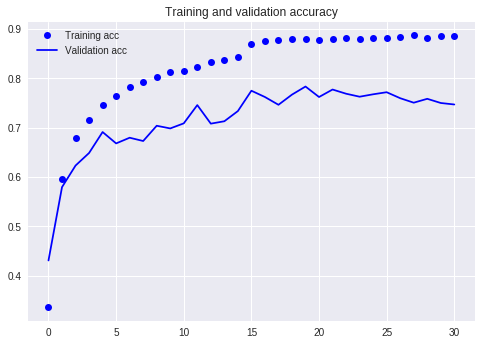

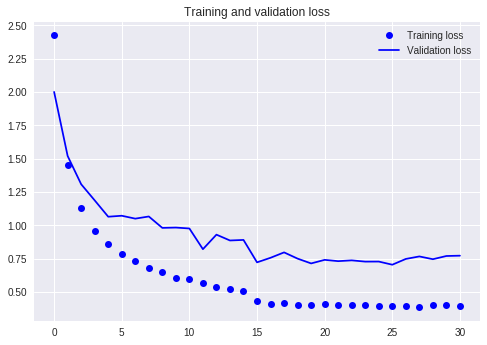

In [18]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [24]:
test_loss, test_acc = model.evaluate_generator(test1_generator,steps=len(test1_generator)/BATCH_SIZE)
print('test1_acc: ',test_acc)
test_loss, test_acc = model.evaluate_generator(ahe_test_generator,len(ahe_test_generator)/BATCH_SIZE)
print('ahe_test_acc: ',test_acc)
test_loss, test_acc = model.evaluate_generator(ahe_neg_test_generator,len(ahe_neg_test_generator)/BATCH_SIZE)
print('ahe__neg_test_acc: ',test_acc)

test_loss, test_acc = model.evaluate_generator(fc_ahe_test_generator,len(fc_ahe_test_generator)/BATCH_SIZE)
print('fc_ahe_test_acc: ',test_acc)
test_loss, test_acc = model.evaluate_generator(fc_ahe_neg_test_generator,len(fc_ahe_neg_test_generator)/BATCH_SIZE)
print('fc_ahe__neg_test_acc: ',test_acc)

test1_acc:  0.9257142884390694
ahe_test_acc:  0.9199999911444527
ahe__neg_test_acc:  0.9371428574834552
fc_ahe_test_acc:  0.8971428615706307
fc_ahe__neg_test_acc:  0.9199999911444527


In [0]:
from shutil import copyfile
copyfile('handsigns.h5', '/content/gdrive/My Drive/copied_handsigns_preFT.h5')
model.save('/content/gdrive/My Drive/saved_handsigns_preFT.h5')

In [0]:
#fine tuning the model
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [27]:
optimizer = keras.optimizers.RMSprop(lr=0.0001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

callbacks_list = [ callbacks.EarlyStopping(monitor='acc', patience=3), 
                  callbacks.ModelCheckpoint(filepath = 'handsigns.h5', 
                  monitor = 'val_loss', 
                  save_best_only = True), 
                  callbacks.ReduceLROnPlateau(monitor='val_loss', 
                  factor = 0.1, 
                  patience=3) ]


history = model.fit_generator(train_generator,
                    epochs=NUM_EPOCHS,
                    callbacks = callbacks_list,
                    verbose = 1,
                    steps_per_epoch = steps_per_epoch_train,
                    validation_steps = steps_per_epoch_val,
                    validation_data=validation_generator)



Epoch 1/40
594/593 [==============================] - 240s 404ms/step - loss: 0.6081 - acc: 0.8254 - val_loss: 0.5887 - val_acc: 0.8224
Epoch 2/40
594/593 [==============================] - 235s 396ms/step - loss: 0.2682 - acc: 0.9164 - val_loss: 0.5107 - val_acc: 0.8679
Epoch 3/40
594/593 [==============================] - 235s 396ms/step - loss: 0.2030 - acc: 0.9395 - val_loss: 0.7062 - val_acc: 0.8430
Epoch 4/40
594/593 [==============================] - 234s 394ms/step - loss: 0.1710 - acc: 0.9510 - val_loss: 0.4234 - val_acc: 0.8824
Epoch 5/40
594/593 [==============================] - 233s 392ms/step - loss: 0.1508 - acc: 0.9554 - val_loss: 0.4945 - val_acc: 0.8964
Epoch 6/40
594/593 [==============================] - 234s 394ms/step - loss: 0.1491 - acc: 0.9605 - val_loss: 0.5055 - val_acc: 0.8988
Epoch 7/40
594/593 [==============================] - 234s 394ms/step - loss: 0.1457 - acc: 0.9614 - val_loss: 0.4658 - val_acc: 0.8994
Epoch 8/40
594/593 [============================

In [0]:
model.save('/content/gdrive/My Drive/handsignsFT.h5')

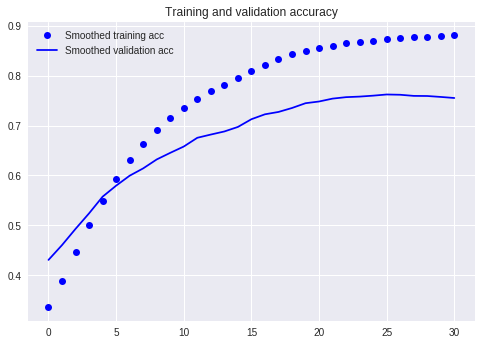

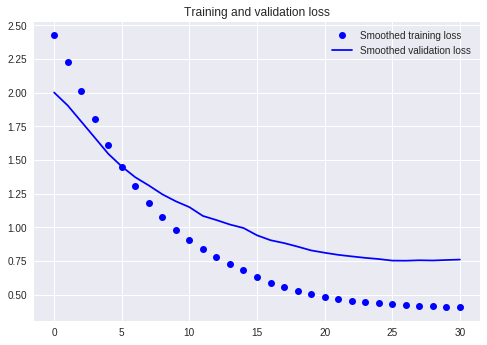

In [28]:
def smooth_curve(points, factor=0.8):
  smoothed_points = []
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous * factor + point * (1 - factor))
    else:
      smoothed_points.append(point)
  return smoothed_points

plt.plot(epochs,
         smooth_curve(acc), 'bo', label='Smoothed training acc')
plt.plot(epochs,
         smooth_curve(val_acc), 'b', label='Smoothed validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs,
         smooth_curve(loss), 'bo', label='Smoothed training loss')
plt.plot(epochs,
         smooth_curve(val_loss), 'b', label='Smoothed validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [29]:
test_loss, test_acc = model.evaluate_generator(test1_generator,steps=len(test1_generator)/BATCH_SIZE)
print('test1_acc: ',test_acc)
test_loss, test_acc = model.evaluate_generator(ahe_test_generator,len(ahe_test_generator)/BATCH_SIZE)
print('ahe_test_acc: ',test_acc)
test_loss, test_acc = model.evaluate_generator(ahe_neg_test_generator,len(ahe_neg_test_generator)/BATCH_SIZE)
print('ahe__neg_test_acc: ',test_acc)

test_loss, test_acc = model.evaluate_generator(fc_ahe_test_generator,len(fc_ahe_test_generator)/BATCH_SIZE)
print('fc_ahe_test_acc: ',test_acc)
test_loss, test_acc = model.evaluate_generator(fc_ahe_neg_test_generator,len(fc_ahe_neg_test_generator)/BATCH_SIZE)
print('fc_ahe__neg_test_acc: ',test_acc)

test1_acc:  0.9885714309556144
ahe_test_acc:  0.9942857112203326
ahe__neg_test_acc:  0.9885714224406651
fc_ahe_test_acc:  1.0
fc_ahe__neg_test_acc:  1.0


In [0]:
# atudy miss classified images
fnames = validation_generator.filenames
 
ground_truth = validation_generator.classes
 
label2index = validation_generator.class_indices
 
# Getting the mapping from class index to class label
idx2label = dict((v,k) for k,v in label2index.iteritems())
 
predictions = model.predict_classes(validation_features)
prob = model.predict(validation_features)
 
errors = np.where(predictions != ground_truth)[0]
print("No of errors = {}/{}".format(len(errors),nVal))

In [0]:
for i in range(len(errors)):
    pred_class = np.argmax(prob[errors[i]])
    pred_label = idx2label[pred_class]
     
    print('Original label:{}, Prediction :{}, confidence : {:.3f}'.format(
        fnames[errors[i]].split('/')[0],
        pred_label,
        prob[errors[i]][pred_class]))
     
    original = load_img('{}/{}'.format(validation_dir,fnames[errors[i]]))
    plt.imshow(original)
    plt.show()

In [0]:
# heat charts for each test image dataset


In [0]:
# algorithm for maximizing predictability using all test prediction datasets